
## Modified from CIS 530 Homework Option 2 - Spring 2021




### Installing the Huggingface🤗 transformer package

In [1]:
# os.environ['CUDA_LAUNCH_BLOCKING'] = "0"
!pip install transformers
!pip3 install sentencepiece
!pip install madgrad
type_name = "Neutrality"

     |████████████████████████████████| 2.1MB 8.6MB/s 
     |████████████████████████████████| 901kB 51.4MB/s 
     |████████████████████████████████| 3.3MB 56.0MB/s 
     |████████████████████████████████| 1.2MB 8.6MB/s 


In [2]:
train_set_name = "All"

### Import the important packages that we need

In [3]:
import torch 
import numpy as np
import pandas as pd

### Mount your google drive 


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
def get_metrics(true_labels, pred_labels):
    f1 = f1_score(true_labels, pred_labels, average='macro')
    acc = accuracy_score(true_labels, pred_labels)
    rec = recall_score(true_labels, pred_labels, average='macro')
    prec = precision_score(true_labels, pred_labels, average='macro')
    return f1, acc, rec, prec

### Download the Review Datset

Note that with the default code, the files are not saved in your google drive, which means they will get deleted after the session close. You can either re-run this cell for each new colab session, or you can save it to the mounted drive at `/content/drive`

In [6]:
import json
import gzip

def parse(path):
  true = True
  false = False
  g = gzip.open(path, 'r')
  for l in g:
    yield json.dumps(eval(l))

def strict(path):
  max_reviews = 1689188
  iter = 5000
  counter = 0 
  f_path = path + ".json.gz"
  true = True
  false = False
  f = open(path+".json", 'w')
  # f.write("[")
  writable = "["
  # writable.join

  for l in parse(f_path):
    writable = writable + l + ',\n'
    counter = counter + 1
    if (counter % iter) == 0:
      print(f"On line{counter}, {counter/max_reviews} % done")
  writable = writable[:-2]
  writable = writable + "]"
  f.write(writable)

def fast_parse(path):
  # path = path + ".json.gz"
  max_reviews = 1689188
  iter = 5000
  counter = 0 
  all_reviews = []
  g = open(path, 'r')
  for line in g:
    d = json.loads(line)
    all_reviews.append(d)
    if (counter % iter) == 0:
      print(f"On line{counter}, {counter/max_reviews} % done")
    counter = counter + 1
  return all_reviews

In [7]:
#Csvs

# train_set = pd.read_csv('/content/drive/Shareddrives/519 Project/Data/preprocessed/Final Data/all_train.csv')
# dev_set = pd.read_csv('/content/drive/Shareddrives/519 Project/Data/preprocessed/Final Data/all_test.csv')
# experiment_set = pd.read_csv('/content/drive/Shareddrives/519 Project/Data/preprocessed/Final Data/electronics_test.csv')
# train_set = train_set.to_dict(orient='records')
# dev_set = dev_set.to_dict(orient='records')
# experiment_set = experiment_set.to_dict(orient='records')

#Jsons

train_set = fast_parse('/content/drive/Shareddrives/519 Project/Data/preprocessed/Final Data/neutrality_binary_train.json')
dev_set = fast_parse('/content/drive/Shareddrives/519 Project/Data/preprocessed/Final Data/neutrality_binary_test.json')
experiment_set = fast_parse('/content/drive/Shareddrives/519 Project/Data/preprocessed/Final Data/neutrality_binary_test.json')
  


On line0, 0.0 % done
On line5000, 0.002960002083841467 % done
On line10000, 0.005920004167682934 % done
On line15000, 0.008880006251524401 % done
On line20000, 0.011840008335365868 % done
On line25000, 0.014800010419207334 % done
On line30000, 0.017760012503048803 % done
On line35000, 0.02072001458689027 % done
On line40000, 0.023680016670731736 % done
On line45000, 0.026640018754573204 % done
On line50000, 0.02960002083841467 % done
On line55000, 0.03256002292225614 % done
On line60000, 0.035520025006097605 % done
On line65000, 0.03848002708993907 % done
On line70000, 0.04144002917378054 % done
On line75000, 0.04440003125762201 % done
On line80000, 0.04736003334146347 % done
On line85000, 0.050320035425304936 % done
On line90000, 0.05328003750914641 % done
On line95000, 0.05624003959298787 % done
On line0, 0.0 % done
On line5000, 0.002960002083841467 % done
On line10000, 0.005920004167682934 % done
On line15000, 0.008880006251524401 % done
On line20000, 0.011840008335365868 % done
On 

### Load the dataset and see what it looks like

For now let's first load the training dataset and see what it looks like. We will worry about the dev/test sets later...


In [8]:
print(train_set[0]['title_plus_review'])
print("Number of review in training set: {}".format(len(train_set)))
print("Here's how one of the example looks like: {}".format(json.dumps(train_set[100])))

lasted for about three cycles and will not keep a charge  ...  lasted for about three cycles and will not keep a charge .  went to the battery recycles !   both of them ..... i bought two as a set to run an electric cart . 
Number of review in training set: 99992
Here's how one of the example looks like: {"Unnamed: 0": 38896, "reviewText": "Cheap looking and obviously plastic. Just junk.", "summary": "Cheap looking plastic", "title_plus_review": "cheap looking plastic cheap looking and obviously plastic .  just junk . ", "pos_neg": 0, "neutrality": 1, "num_words": 10, "nw": 7}


In [9]:
import random

training_reviews = []
id = 0;
for  review in train_set:
  if 'title_plus_review' not in review:
    continue
  training_reviews.append({
            "review_id": id,
            "review_text": str(review['title_plus_review']).encode('utf-8'),
            "label": review['neutrality']
        })
  
  id = id + 1
print("Number of reviews for training: {}".format(len(training_reviews)))

dev_reviews = []
id = 0;
for review in dev_set:
  #no Review text
  if 'title_plus_review' not in review:
    continue
  dev_reviews.append({
            "review_id": id,
            "review_text": str(review['title_plus_review']).encode('utf-8'),
            "label": review['neutrality']
        })
  
  id = id + 1
print("Number of reviews for dev: {}".format(len(dev_reviews)))

experiment_reviews = []
id = 0;
for review in experiment_set:
  #no Review text
  if 'title_plus_review' not in review:
    continue
  experiment_reviews.append({
            "review_id": id,
            "review_text": str(review['title_plus_review']).encode('utf-8'),
            "label": review['neutrality']
        })
  
  id = id + 1
print("Number of reviews for experiment: {}".format(len(experiment_reviews)))

Number of reviews for training: 99992
Number of reviews for dev: 39612
Number of reviews for experiment: 39612


### Load Pretrained BERT Model
 

You can search for the available models [here](https://huggingface.co/models?search=bert).

You can find more examples of different use cases for BERT in the transformer github repo README -- https://github.com/huggingface/transformers


In [10]:
from transformers import InputExample
from transformers import (WEIGHTS_NAME, BertConfig,
                          BertForSequenceClassification, BertTokenizer)
from transformers import glue_convert_examples_to_features as convert_examples_to_features
from transformers.optimization import AdamW, get_linear_schedule_with_warmup
import tqdm

from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,  TensorDataset)


#Bert-mini 
bert_model_type = 'bert-base-uncased'
bert_model = BertForSequenceClassification.from_pretrained(bert_model_type, num_labels = 2)
config = BertConfig.from_pretrained(bert_model_type)
tokenizer = BertTokenizer.from_pretrained(bert_model_type, num_labels = 2)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

### Convert examples to BERT input features



In [11]:
relevance_label_mapping = {
    0.0: 0,
    1.0: 1
}

def convert_sentence_pair_to_tensor_input(sentence_reviews, label_mapping):

    # STEP 1: convert each sentence 
    input_examples = []
    for review in sentence_reviews:
        current_label = review["label"] if "label" in review else print("dang")
        input_examples.append(
            InputExample(guid=review["review_id"], 
                         text_a=str(review["review_text"]), 
                         label=label_mapping[current_label])
        )

    label_list = [val for _, val in label_mapping.items()]
    features = convert_examples_to_features(input_examples,
                                                   tokenizer,
                                                   label_list=label_list,
                                                   max_length = 128,  
                                                   output_mode="classification")
    
    input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    attention_mask = torch.tensor([f.attention_mask for f in features], dtype=torch.long)
    token_type_ids = torch.tensor([f.token_type_ids for f in features], dtype=torch.long)
    labels = torch.tensor([f.label for f in features], dtype=torch.long)
    dataset = TensorDataset(input_ids, attention_mask, token_type_ids, labels)

    return dataset

In [12]:
train_dataset = convert_sentence_pair_to_tensor_input(training_reviews, relevance_label_mapping)

/usr/local/lib/python3.7/dist-packages/transformers/data/processors/glue.py:67: FutureWarning: This function will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("function"), FutureWarning)


In [13]:
dev_dataset = convert_sentence_pair_to_tensor_input(dev_reviews, relevance_label_mapping)

/usr/local/lib/python3.7/dist-packages/transformers/data/processors/glue.py:67: FutureWarning: This function will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("function"), FutureWarning)


In [14]:
experiment_dataset = convert_sentence_pair_to_tensor_input(experiment_reviews, relevance_label_mapping)

/usr/local/lib/python3.7/dist-packages/transformers/data/processors/glue.py:67: FutureWarning: This function will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("function"), FutureWarning)


### Choose your hyperparameters + model output directory


In [ ]:
HYPER_PARAMS = {
    "num_training_epoch": 3,
    "learning_rate": 1e-5,        
    "training_batch_size": 32,    
    "eval_batch_size": 8,
    "max_grad_norm": 1.0,
    "num_warmup_steps": 0.1,
    "dropout_prob": 0.5
}


In [ ]:
torch.cuda.manual_seed(42)
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

bert_model.hidden_dropout_prob = HYPER_PARAMS['dropout_prob']
bert_model.to("cuda")
optimizer = AdamW(bert_model.parameters(), 
                    lr=HYPER_PARAMS['learning_rate'], 
                    correct_bias=False)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, 
                              sampler=train_sampler, 
                              batch_size=HYPER_PARAMS["training_batch_size"])

# optimizer = AdamW(bert_model.parameters(), 
#                   lr=HYPER_PARAMS['learning_rate'], 
#                   correct_bias=False)

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=HYPER_PARAMS['num_warmup_steps'], 
                                            num_training_steps=len(train_dataloader))


global_step = 0
tr_loss = 0.0
bert_model.zero_grad()
bert_model.train()

for epc in range(HYPER_PARAMS["num_training_epoch"]):
    print("Epoch #{}: \n".format(epc))
    epoch_iterator = tqdm.notebook.tqdm(train_dataloader, desc="Training Steps")
    avg_loss_over_epoch = []
    for step, batch in enumerate(epoch_iterator):
        batch = tuple(t.to('cuda') for t in batch)
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'token_type_ids': batch[2],
                  'labels': batch[3]}

        outputs = bert_model(**inputs)
        loss = outputs[0]  
        loss.backward()
        torch.nn.utils.clip_grad_norm_(bert_model.parameters(), HYPER_PARAMS["max_grad_norm"])
        tr_loss += loss.item()

        optimizer.step()
        scheduler.step()
        bert_model.zero_grad()

Epoch #0: 




Epoch #1: 




Epoch #2: 



In [ ]:
import os
output_dir = '/content/drive/MyDrive/cis519_final/Bert-Base Models/all_neut_bert_base_adam/'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

bert_model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
config.save_pretrained(output_dir)

Load Model


In [ ]:
output_dir = '/content/drive/MyDrive/cis519_final/Bert-Base Models/all_neut_bert_base_adam/'
bert_model = BertForSequenceClassification.from_pretrained(output_dir, num_labels = 2)
tokenizer = BertTokenizer.from_pretrained(output_dir, num_labels = 2)

bert_model = bert_model.to("cuda")
  

In [ ]:
results = pd.DataFrame(columns=['Type', "Model", 'Optimizer', "Train Set", 'Test Set', 'LR', 'Dropout','F1', 'Accuracy', 'Recall', 'Precision' ])
optimizer_name = "ADAM"
test_set_name = "All"

In [ ]:

dev_sampler = SequentialSampler(dev_dataset)
dev_dataloader = DataLoader(dev_dataset, 
                            sampler=dev_sampler, 
                            batch_size=HYPER_PARAMS["eval_batch_size"])

predictions = None
out_label_ids = None

for batch in tqdm.notebook.tqdm(dev_dataloader, desc="Evaluating on Dev set..."):
    bert_model.eval()
    batch = tuple(t.to("cuda") for t in batch)
    inputs = {'input_ids': batch[0],
              'attention_mask': batch[1],
              'token_type_ids': batch[2],
              'labels': batch[3]}

    with torch.no_grad():
        outputs = bert_model(**inputs)
        logits = outputs[1] # This is 1x2 tensor, containing scores for both labels 
    if predictions is None:
        predictions = logits.detach().cpu().numpy()
        out_label_ids = inputs['labels'].detach().cpu().numpy()
    else:
        predictions = np.append(predictions, logits.detach().cpu().numpy(), axis=0)
        out_label_ids = np.append(out_label_ids, inputs['labels'].detach().cpu().numpy(), axis=0)

# whichever label gets higher score, we will predict that label
predictions = np.argmax(predictions, axis=1)
# print(predictions)
# print(out_label_ids)


f1, acc, rec, prec = get_metrics(out_label_ids, predictions)
row = {'Type': type_name, 'Model':bert_model_type, 'Optimizer':optimizer_name, "Train Set": train_set_name, "Test Set": test_set_name, 'LR': HYPER_PARAMS['learning_rate'], 'Dropout':HYPER_PARAMS['dropout_prob'], 'F1': f1, 'Accuracy': acc, 'Recall': rec, 'Precision':prec}
print("The accuracy on dev set = {}".format(acc))
results = results.append(row, ignore_index = True)
results.to_csv(output_dir +"results.csv")


The accuracy on dev set = 0.9111885287286681


In [ ]:
results

,Type,Model,Optimizer,Train Set,Test Set,LR,Dropout,F1,Accuracy,Recall,Precision
0,Neutrality,bert-base-uncased,ADAM,All,All,0.00001,0.5,0.805117,0.911189,0.898946,0.757365


Test on other dataset

In [ ]:
# test_set_name = "Elec"

In [ ]:
# dev_sampler = SequentialSampler(experiment_dataset)
# dev_dataloader = DataLoader(experiment_dataset, 
#                             sampler=dev_sampler, 
#                             batch_size=HYPER_PARAMS["eval_batch_size"])

# predictions = None
# out_label_ids = None

# for batch in tqdm.notebook.tqdm(dev_dataloader, desc="Evaluating on Experiment set..."):
#     bert_model.eval()
#     batch = tuple(t.to("cuda") for t in batch)
#     inputs = {'input_ids': batch[0],
#               'attention_mask': batch[1],
#               'token_type_ids': batch[2],
#               'labels': batch[3]}

#     with torch.no_grad():
#         outputs = bert_model(**inputs)
#         logits = outputs[1] # This is 1x2 tensor, containing scores for both labels 
#     if predictions is None:
#         predictions = logits.detach().cpu().numpy()
#         out_label_ids = inputs['labels'].detach().cpu().numpy()
#     else:
#         predictions = np.append(predictions, logits.detach().cpu().numpy(), axis=0)
#         out_label_ids = np.append(out_label_ids, inputs['labels'].detach().cpu().numpy(), axis=0)

# # whichever label gets higher score, we will predict that label
# predictions = np.argmax(predictions, axis=1)
# # print(predictions)
# # print(out_label_ids)


# f1, acc, rec, prec = get_metrics(out_label_ids, predictions)
# row = {'Type': type_name, 'Model':bert_model_type, 'Optimizer':optimizer_name, "Train Set": train_set_name, "Test Set": test_set_name, 'LR': HYPER_PARAMS['learning_rate'], 'Dropout':HYPER_PARAMS['dropout_prob'], 'F1': f1, 'Accuracy': acc, 'Recall': rec, 'Precision':prec, }
# print("The accuracy on dev set = {}".format(acc))
# results = results.append(row, ignore_index = True)
# results.to_csv(output_dir +"results.csv")

In [ ]:
results

,Type,Model,Optimizer,Train Set,Test Set,LR,Dropout,F1,Accuracy,Recall,Precision
0,Neutrality,bert-base-uncased,ADAM,All,All,0.00001,0.5,0.805117,0.911189,0.898946,0.757365


##MADGRAD

In [15]:
bert_model = BertForSequenceClassification.from_pretrained(bert_model_type, num_labels = 2)
config = BertConfig.from_pretrained(bert_model_type)
tokenizer = BertTokenizer.from_pretrained(bert_model_type, num_labels = 2)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [19]:
HYPER_PARAMS = {
    "num_training_epoch": 3,
    "learning_rate": 1e-4,        
    "training_batch_size": 32,    
    "eval_batch_size": 8,
    "max_grad_norm": 1.0,
    "num_warmup_steps": 0.1,
    "dropout_prob": 0.1
}

In [ ]:
from madgrad import MADGRAD
torch.cuda.manual_seed(42)
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

bert_model.hidden_dropout_prob = HYPER_PARAMS['dropout_prob']
bert_model.to("cuda")
optimizer = MADGRAD(bert_model.parameters(), 
                    lr=HYPER_PARAMS['learning_rate'])
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, 
                              sampler=train_sampler, 
                              batch_size=HYPER_PARAMS["training_batch_size"])

# optimizer = AdamW(bert_model.parameters(), 
#                   lr=HYPER_PARAMS['learning_rate'], 
#                   correct_bias=False)

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=HYPER_PARAMS['num_warmup_steps'], 
                                            num_training_steps=len(train_dataloader))


global_step = 0
tr_loss = 0.0
bert_model.zero_grad()
bert_model.train()

for epc in range(HYPER_PARAMS["num_training_epoch"]):
    print("Epoch #{}: \n".format(epc))
    epoch_iterator = tqdm.notebook.tqdm(train_dataloader, desc="Training Steps")
    avg_loss_over_epoch = []
    for step, batch in enumerate(epoch_iterator):
        batch = tuple(t.to('cuda') for t in batch)
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'token_type_ids': batch[2],
                  'labels': batch[3]}

        outputs = bert_model(**inputs)
        loss = outputs[0]  
        loss.backward()
        torch.nn.utils.clip_grad_norm_(bert_model.parameters(), HYPER_PARAMS["max_grad_norm"])
        tr_loss += loss.item()

        optimizer.step()
        scheduler.step()
        bert_model.zero_grad()

Epoch #0: 




Epoch #1: 




Epoch #2: 



In [ ]:
import os
# This is where we mounted your google drive. 
# You might need to re-mount it if your session was closed half way through
output_dir = '/content/drive/MyDrive/cis519_final/Bert-Base Models/all_neut_bert_base_madgrad/'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

bert_model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
config.save_pretrained(output_dir)


Load Model


In [16]:
output_dir = '/content/drive/MyDrive/cis519_final/Bert-Base Models/all_neut_bert_base_madgrad/'
bert_model = BertForSequenceClassification.from_pretrained(output_dir, num_labels = 2)
tokenizer = BertTokenizer.from_pretrained(output_dir, num_labels = 2)

bert_model = bert_model.to("cuda")

In [17]:
results = pd.DataFrame(columns=['Type', "Model", 'Optimizer', "Train Set", 'Test Set', 'LR', 'Dropout','F1', 'Accuracy', 'Recall', 'Precision' ])
test_set_name = "All"
optimizer_name = "Madgrad"

In [20]:
dev_sampler = SequentialSampler(dev_dataset)
dev_dataloader = DataLoader(dev_dataset, 
                            sampler=dev_sampler, 
                            batch_size=HYPER_PARAMS["eval_batch_size"])

predictions = None
out_label_ids = None

for batch in tqdm.notebook.tqdm(dev_dataloader, desc="Evaluating on Dev set..."):
    bert_model.eval()
    batch = tuple(t.to("cuda") for t in batch)
    inputs = {'input_ids': batch[0],
              'attention_mask': batch[1],
              'token_type_ids': batch[2],
              'labels': batch[3]}

    with torch.no_grad():
        outputs = bert_model(**inputs)
        logits = outputs[1] # This is 1x2 tensor, containing scores for both labels 
    if predictions is None:
        predictions = logits.detach().cpu().numpy()
        out_label_ids = inputs['labels'].detach().cpu().numpy()
    else:
        predictions = np.append(predictions, logits.detach().cpu().numpy(), axis=0)
        out_label_ids = np.append(out_label_ids, inputs['labels'].detach().cpu().numpy(), axis=0)

# whichever label gets higher score, we will predict that label
predictions = np.argmax(predictions, axis=1)
# print(predictions)
# print(out_label_ids)


f1, acc, rec, prec = get_metrics(out_label_ids, predictions)
row = {'Type': type_name, 'Model':bert_model_type, 'Optimizer':optimizer_name, "Train Set": train_set_name, "Test Set": test_set_name, 'LR': HYPER_PARAMS['learning_rate'], 'Dropout':HYPER_PARAMS['dropout_prob'], 'F1': f1, 'Accuracy': acc, 'Recall': rec, 'Precision':prec, }
print("The accuracy on dev set = {}".format(acc))
results = results.append(row, ignore_index = True)
results.to_csv(output_dir+"results.csv")


The accuracy on dev set = 0.9133848328789256


In [ ]:
results

,Type,Model,Optimizer,Train Set,Test Set,LR,Dropout,F1,Accuracy,Recall,Precision
0,Neutrality,bert-base-uncased,Madgrad,All,All,0.0001,0.1,0.808192,0.913385,0.898788,0.760857


Prediction
1             33222
0              6390
dtype: int64


Text(0.5, 1.0, 'All Categories Neutrality Predictions, BERT-Base')

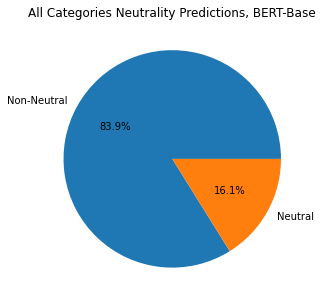

In [23]:
import matplotlib.pyplot as plt
pred =predictions.astype(int) 
df = pd.DataFrame(pred, columns=["Prediction"])
val_count = df.value_counts()
print(val_count)
# ax = val_count.plot(kind='pie', y ="Prediction")
labels = ['Non-Neutral','Neutral']
plot = val_count.plot.pie(y="Prediction", figsize=(5, 5), labels = labels, autopct='%1.1f%%')
plt.ylabel("")
plt.title("All Categories Neutrality Predictions, BERT-Base")

Test experiment

In [ ]:
# test_set_name = "Elec"

In [ ]:
# dev_sampler = SequentialSampler(experiment_dataset)
# dev_dataloader = DataLoader(experiment_dataset, 
#                             sampler=dev_sampler, 
#                             batch_size=HYPER_PARAMS["eval_batch_size"])

# predictions = None
# out_label_ids = None

# for batch in tqdm.notebook.tqdm(dev_dataloader, desc="Evaluating on Experiment set..."):
#     bert_model.eval()
#     batch = tuple(t.to("cuda") for t in batch)
#     inputs = {'input_ids': batch[0],
#               'attention_mask': batch[1],
#               'token_type_ids': batch[2],
#               'labels': batch[3]}

#     with torch.no_grad():
#         outputs = bert_model(**inputs)
#         logits = outputs[1] # This is 1x2 tensor, containing scores for both labels 
#     if predictions is None:
#         predictions = logits.detach().cpu().numpy()
#         out_label_ids = inputs['labels'].detach().cpu().numpy()
#     else:
#         predictions = np.append(predictions, logits.detach().cpu().numpy(), axis=0)
#         out_label_ids = np.append(out_label_ids, inputs['labels'].detach().cpu().numpy(), axis=0)

# # whichever label gets higher score, we will predict that label
# predictions = np.argmax(predictions, axis=1)
# # print(predictions)
# # print(out_label_ids)


# f1, acc, rec, prec = get_metrics(out_label_ids, predictions)
# row = {'Type': type_name, 'Model':bert_model_type, 'Optimizer':optimizer_name, "Train Set": train_set_name, "Test Set": test_set_name, 'LR': HYPER_PARAMS['learning_rate'], 'Dropout':HYPER_PARAMS['dropout_prob'], 'F1': f1, 'Accuracy': acc, 'Recall': rec, 'Precision':prec, }
# print("The accuracy on dev set = {}".format(acc))
# results = results.append(row, ignore_index = True)
# results.to_csv(output_dir +"results.csv")

In [ ]:
results

,Type,Model,Optimizer,Train Set,Test Set,LR,Dropout,F1,Accuracy,Recall,Precision
0,Neutrality,bert-base-uncased,Madgrad,All,All,0.0001,0.1,0.808192,0.913385,0.898788,0.760857
